# Práctica 4b: selección de características categóricas

**Nota:** antes de implementar los siguientes métodos, debemos asegurarnos de que el `DataFrame` sólo contiene características categóricas.

### Preparación del conjunto de datos: Breast Cancer

En el conjunto de datos se encuentran datos de las pacientes con cáncer de mama con una recurrencia o no recurrencia del cáncer. Hay 286 ejemplos y nueve variables de entrada. Es un problema de clasificación binaria.

Un modelo trivial puede lograr una precisión del \(70%\) en este conjunto de datos. Un buen puntaje es de aproximadamente \(76% +/- 3%\).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
low_memory = False
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


In [2]:
file = "../../conjunto_de_datos_visita_museos_2018.csv"
df = pd.read_csv(file)
df = df.dropna(axis=1)
names = ['ANIO_ESTAD', 'ENT_REGIS', 'MES_ENTREV', 'DIA_ENTREV', 'SEXO', 'EDAD',
       'ENT_RESID', 'MUN_RESID', 'PAIS_RESID', 'NACIONALID', 'PAIS_EXTRA',
       'ESCOLARIDA', 'OCUPACION', 'LENGUA_1', 'ESTIM_FAM', 'PRIM_VISIT',
       'VIS_OTROS', 'MEDIO_1', 'PLAN_VISIT', 'MV_ACOMP', 'MV_CULTURA',
       'MV_APREND', 'MV_ESCOLAR', 'MV_LABORAL', 'MV_CONOCER', 'MV_ENTRETE',
       'MV_EDIFICI', 'MV_TALLER', 'MV_OTRO', 'MEDIO_TRAN', 'TIEMPO_TRA',
       'TIPO_ENTRA', 'PAV_NADIE', 'PAV_FAMILI', 'PAV_PAREJA', 'PAV_AMIGO',
       'PAV_COMPA', 'PAV_ESCOLA', 'PAV_TURIST', 'PAV_OTRO', 'SU_SALAS',
       'SU_TIENDA', 'SU_VISGUIA', 'SU_AUDIOG', 'SU_TALLER', 'SU_ACADEM',
       'SU_ACULTUR', 'SU_BIBLIOT', 'SU_ARCHIVO', 'SU_SILLA', 'SU_OTRO',
       'OPIN_EXPOS', 'DUR_VIS_H', 'DUR_VIS_M', 'REPETIR_VI', 'RECOMIE_VI',
       'EVAL_GRAL', 'M_NOVIS_1']
df = df.astype(int)
for i in names :
    #print(len(df[i].unique()))
    if(len(df[i].unique()) == 2):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b"
        }, inplace=True)
    if(len(df[i].unique()) == 3):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b",
            x[2] : "c"
        }, inplace=True)
    if(len(df[i].unique()) > 3):
        bins=np.linspace(min(df[i]),max(df[i]),4)
        names=["a","b","c"]
        df[i]=pd.cut(df[i],bins,labels=names)
df = df.dropna(axis = 1)
df = df.drop("ANIO_ESTAD", 1)
X = df.drop("SEXO",1)
y = df["SEXO"]
df = pd.concat([X, y], axis = 1)
df.to_csv("Archivo.csv", header = True, index = False)

In [3]:
file = "Archivo.csv"
data = pd.read_csv(file, header=None)
# arreglo
dataset = data.values

Una vez cargado el conjunto de datos, podemos dividirlo en datos de entrada o características (X) y salida variable de salida o target (y).

In [4]:
X = dataset[:, :-1]
y = dataset[:,-1]

Podemos forzar que todos los campos de los datos de entrada sean `string`, por si acaso Pandas malinterpretara alguna variable.

In [5]:
X = X.astype(str)

Podemos juntar este proceso en una función que podemos reutilizar más tarde.

In [6]:

def load_dataset(filename):
    # Cargamos el Dataframe
    data = pd.read_csv(filename, header=None)
    # Generamos un arreglo
    dataset = data.values
    # Dividimos en X y y
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # Forzamos que X sea string 
    X = X.astype(str)
    return X, y

Una vez cargados los datos, podemos dividirlos en conjuntos de entrenamiento (*train*) y pruebas (*test*) para que podamos encontar y evaluar un modelo de aprendizaje. Utilizaremos la función `train_test_split()` de scikit-learn y utilizaremos el 67% de los datos para el entrenamiento y el 33% para las pruebas.

In [7]:
# Cargamos el dataset
X, y = load_dataset(file)

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Checamos las dimensiones
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (122455, 37) (122455,)
Test (60315, 37) (60315,)


Podemos usar el `OrdinalEncoder()` de scikit-learn para codificar cada variable categórica a números enteros. Esta es una clase flexible y permite especificar el orden de las categorías como argumentos si se conoce dicho orden.

In [8]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    oe.fit(X_test)
    X_test_enc =  oe.transform(X_test)
    return X_train_enc, X_test_enc
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

También necesitamos preparar la variable target. Este un problema de clasificación binaria, por lo que necesitamos convertir las dos etiquetas categóricas a binarias, 0 y 1, este es un tipo de codificación ordinal. Scikit-learn proporciona la clase `LabelEncoder` diseñada específicamente para este propósito. Podríamos usar el `OrdinalEncoder` y obtener el mismo resultado, aunque el `LabelEncoder` está diseñado para codificar una sola variable.

La función `prepare_targets()` codifica los datos de salida para el train y test.

In [9]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    le.fit(y_test)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Chi-Squared

La prueba de hipótesis estadística chi-cuadrado de Pearson (Chi-squared) es un ejemplo de una prueba de independencia entre variables categóricas. Los resultados de esta prueba se pueden utilizar para la selección de características, donde aquellas características que son independientes de la variable objetivo se pueden eliminar del conjunto de datos.

La función `chi2()` puede utilizarse para la selección de las características más relevantes de k (valores más grandes) a través de la clase `SelectKBest`. Por ejemplo, podemos definir la clase `SelectKBest` para utilizar la función `chi2()` y seleccionar todas las características.

In [10]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [11]:
# Selección de características con chi-squared
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 1.529338
Característica 1: 1.300473
Característica 2: 4.937005
Característica 3: 7.260486
Característica 4: 2.551268
Característica 5: 5.196306
Característica 6: 1.785974
Característica 7: 8.957263
Característica 8: 3.118490
Característica 9: 4.522414
Característica 10: 1.467200
Característica 11: 1.432662
Característica 12: 1.625090
Característica 13: 3.628840
Característica 14: 1.553032
Característica 15: 1.009721
Característica 16: 2.012231
Característica 17: 29.240811
Característica 18: 62.312828
Característica 19: 12.904847
Característica 20: 1.272791
Característica 21: 1.429136
Característica 22: 1.244081
Característica 23: 1.087693
Característica 24: 2.086943
Característica 25: 1.400693
Característica 26: 1.173254
Característica 27: 4.429956
Característica 28: 1.031778
Característica 29: 5.145648
Característica 30: 1.017344
Característica 31: 1.053569
Característica 32: 1.050230
Característica 33: 1.147077
Característica 34: 1.004253
Característica 35: 1.051052

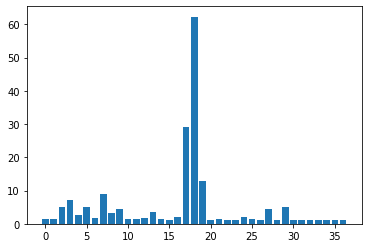

In [12]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Selección de características de información mutua (Mutual Information)

La información mutua del campo de la teoría de la información es la aplicación de la ganancia de información (típicamente usada en la construcción de árboles de decisión) a la selección de características. La información mutua se calcula entre dos variables y mide la reducción de la incertidumbre de una variable dado un valor conocido de la otra variable.

Al igual que `chi2()`, puede utilizarse en la estrategia de selección de características de `SelectKBest` (y otras estrategias).

In [13]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [14]:
# Selección de características con mutual information
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 0.006162
Característica 1: 0.011112
Característica 2: 0.007256
Característica 3: 0.007440
Característica 4: 0.008385
Característica 5: 0.009143
Característica 6: 0.010234
Característica 7: 0.008695
Característica 8: 0.011532
Característica 9: 0.010420
Característica 10: 0.011601
Característica 11: 0.008269
Característica 12: 0.009140
Característica 13: 0.010507
Característica 14: 0.011207
Característica 15: 0.015817
Característica 16: 0.007460
Característica 17: 0.010638
Característica 18: 0.010719
Característica 19: 0.009911
Característica 20: 0.008594
Característica 21: 0.012671
Característica 22: 0.010741
Característica 23: 0.016370
Característica 24: 0.013656
Característica 25: 0.009653
Característica 26: 0.009719
Característica 27: 0.006303
Característica 28: 0.012188
Característica 29: 0.014539
Característica 30: 0.014662
Característica 31: 0.014349
Característica 32: 0.013158
Característica 33: 0.012022
Característica 34: 0.013228
Característica 35: 0.010522
Ca

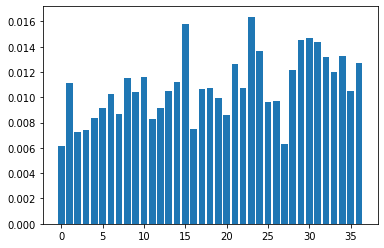

In [15]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()